## Import PuLP package

In [78]:
import pulp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [79]:
# pulp.pulpTestAll()

## Define Constant

割引クーポンによるマーケティングキャンペーンの最適化

- customers.csv             :顧客情報
- visit_probability.csv     :キャンペーン毎の顧客来店確率
- キャンペーンの種類は1.メール、2.メール＋1000円割引クーポン、3.メール＋2000円割引クーポンの3種類

In [80]:
customer_df = pd.read_csv('customers.csv')
visit_prob_df = pd.read_csv('visit_probability.csv')

In [81]:
customer_df.head()

,customer_id,age_cat,freq_cat
0,1,age20~34,freq2
1,2,age35~49,freq0
2,3,age35~49,freq0
3,4,age~19,freq0
4,5,age35~49,freq0


In [82]:
customer_df.shape

(5000, 3)

In [83]:
customer_df.apply(set)

customer_id    {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
age_cat                     {age20~34, age~19, age50~, age35~49}
freq_cat                           {freq0, freq2, freq3~, freq1}
dtype: object

In [84]:
visit_prob_df.head()

,age_cat,freq_cat,segment_id,prob_dm1,prob_dm2,prob_dm3
0,age~19,freq0,1,0.07,0.12,0.29
1,age~19,freq1,2,0.21,0.30,0.58
2,age~19,freq2,3,0.28,0.39,0.74
3,age~19,freq3~,4,0.35,0.45,0.77
4,age20~34,freq0,5,0.11,0.17,0.37


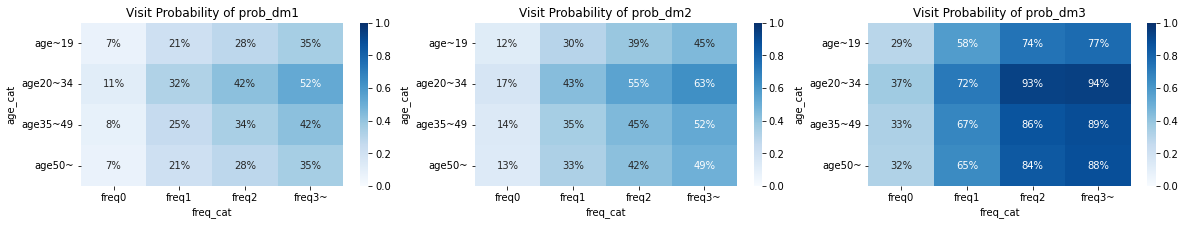

In [85]:
fig, axes = plt.subplots(1,3, figsize=(20,3))
for i, prob in enumerate(['prob_dm1', 'prob_dm2', 'prob_dm3']):
    visit_prob_pivot = pd.pivot_table(visit_prob_df, prob, index='age_cat', columns=['freq_cat'] )
    visit_prob_pivot = visit_prob_pivot.reindex(['age~19', 'age20~34', 'age35~49', 'age50~'])
    sns.heatmap(visit_prob_pivot, ax=axes[i], vmin=0, vmax=1, annot=True, fmt='.0%', cmap='Blues')
    axes[i].set_title(f'Visit Probability of {prob}')
plt.show()

In [86]:
#顧客のリスト
I = customer_df['customer_id'].to_list()
#クーポンのリスト
M = [ 1, 2, 3]

In [87]:
cus_prob_df = pd.merge(customer_df, visit_prob_df, on=['age_cat', 'freq_cat'])
cus_prob_df.head()

,customer_id,age_cat,freq_cat,segment_id,prob_dm1,prob_dm2,prob_dm3
0,1,age20~34,freq2,7,0.42,0.55,0.93
1,199,age20~34,freq2,7,0.42,0.55,0.93
2,200,age20~34,freq2,7,0.42,0.55,0.93
3,255,age20~34,freq2,7,0.42,0.55,0.93
4,269,age20~34,freq2,7,0.42,0.55,0.93


In [88]:
cus_prob_df.shape

(5000, 7)

In [89]:
#セグメントのリスト
S = visit_prob_df['segment_id'].to_list()
S

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

## Create Variable

セグメントsをキャンペーンmに割り当てる確率0-1

In [90]:
# 0-1整数計画問題の場合 binary

xsm={}
for s in S:
    for m in M:
        xsm[s,m] = pulp.LpVariable(f'xsm({s},{m})', lowBound=0, upBound=1, cat='Continuous')

In [91]:
xsm[1,1]

xsm(1,1)

In [92]:
len(xsm)

48

In [93]:
cust_prob_ver_df = cus_prob_df.rename(columns={'prob_dm1':1 , 'prob_dm2':2, 'prob_dm3':3}).melt(id_vars=['customer_id'], value_vars=[1,2,3], var_name='dm', value_name='prob')
cust_prob_ver_df.head()

,customer_id,dm,prob
0,1,1,0.42
1,199,1,0.42
2,200,1,0.42
3,255,1,0.42
4,269,1,0.42


In [94]:
prob_ver_df = visit_prob_df.rename(columns={'prob_dm1':1 , 'prob_dm2':2, 'prob_dm3':3}).melt(id_vars=['segment_id'], value_vars=[1,2,3], var_name='dm', value_name='prob')
prob_ver_df.head()

,segment_id,dm,prob
0,1,1,0.07
1,2,1,0.21
2,3,1,0.28
3,4,1,0.35
4,5,1,0.11


In [95]:
prob_ver_df.shape

(48, 3)

In [97]:
Psm = prob_ver_df.set_index(['segment_id', 'dm'])['prob'].to_dict()
Psm[1,1]

0.07

## Create Model

- `LpProblem('name', sense=LpMinimize or LpMaximize)

In [98]:
prob = pulp.LpProblem('DiscountCouponProblem2', pulp.LpMaximize)

## Create Constraint

In [99]:
# (2) 各セグメントに送るダイレクトメールはいずれか１つ/送付確率の合計が1
for s in S:
    prob += pulp.lpSum([xsm[s, m] for m in M]) == 1

In [100]:
# クーポン金額
Cm = { 1: 0, 2:1000, 3:2000}

In [101]:
Ns = cus_prob_df.groupby(['segment_id'])['customer_id'].count().to_dict()
Ns

{1: 200,
 2: 150,
 3: 50,
 4: 100,
 5: 600,
 6: 450,
 7: 150,
 8: 300,
 9: 800,
 10: 600,
 11: 200,
 12: 400,
 13: 400,
 14: 300,
 15: 100,
 16: 200}

In [103]:
N = 0
for key, val in Ns.items():
    N += val
print(N)

5000


In [104]:
# (4) 顧客の消費する費用の期待値の合計値は100万円以下
prob += pulp.lpSum(xsm[s, m] * Cm[m] * Psm[s, m] * Ns[s] for s in S for m in [2,3]) <= 1000000

In [105]:
# (5) セグメントに属する会員数の10%以上に送付
for s in S:
    for m in M:
        prob += xsm[s,m] >= 0.1

## Create Target function

In [106]:
# 来客数の増加数を最大化
prob += pulp.lpSum(Ns[s] * (Psm[s,m] - Psm[s,1]) * xsm[s,m] for s in S for m in [2,3])

## Exec Solver

- Default solver is CBC. You can use GLPK if installed.

In [107]:
time_start = time.time()
status = prob.solve()
time_stop = time.time()

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/norihito/workspace/optimization-problems/.venv/lib/python3.8/site-packages/pulp/apis/../solverdir/cbc/linux/64/cbc /tmp/a6bdf377022445dcb072bf577be65d08-pulp.mps max timeMode elapsed branch printingOptions all solution /tmp/a6bdf377022445dcb072bf577be65d08-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 70 COLUMNS
At line 231 RHS
At line 297 BOUNDS
At line 346 ENDATA
Problem MODEL has 65 rows, 48 columns and 128 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 17 (-48) rows, 32 (-16) columns and 64 (-64) elements
0  Obj 229 Dual inf 981.57657 (32)
6  Obj 326.0951
Optimal - objective value 326.0951
After Postsolve, objective 326.0951, infeasibilities - dual 11.960784 (3), primal 0 (0)
Presolved model was optimal, full model needs cleaning up
0  Obj 326.0951
Optimal - objective value 326.0951
Optimal objecti

## Check status

- You can check the status by `LpStatus` which shows 
    {0: 'Not Solved', 1: 'Optimal', -1:'Infeasible', -2: 'Unbounded', -3: 'Undefined'}

In [108]:
pulp.LpStatus

{0: 'Not Solved',
 1: 'Optimal',
 -1: 'Infeasible',
 -2: 'Unbounded',
 -3: 'Undefined'}

In [109]:
pulp.LpStatus[prob.status]
# pulp.LpStatus[status]

'Optimal'

## Result 

In [110]:
print(f'目的関数値: {prob.objective.value():.4}')
print(f'計算時間:{(time_stop-time_start):.3}(秒)')

目的関数値: 326.1
計算時間:0.518(秒)


## Verification

In [111]:
send_dm_df = pd.DataFrame([[xsm[s,m].value() for m in M] for s in S], columns=['send_prob_dm1', 'send_prob_dm2', 'send_prob_dm3'])
send_dm_df

,send_prob_dm1,send_prob_dm2,send_prob_dm3
0,0.1,0.800000,0.100000
1,0.8,0.100000,0.100000
2,0.8,0.100000,0.100000
3,0.8,0.100000,0.100000
4,0.8,0.100000,0.100000
5,0.8,0.100000,0.100000
6,0.8,0.100000,0.100000
7,0.8,0.100000,0.100000
8,0.1,0.800000,0.100000
9,0.8,0.100000,0.100000


In [112]:
seg_send_df = pd.concat([visit_prob_df[['segment_id', 'age_cat', 'freq_cat']], send_dm_df], axis=1)
seg_send_df

,segment_id,age_cat,freq_cat,send_prob_dm1,send_prob_dm2,send_prob_dm3
0,1,age~19,freq0,0.1,0.800000,0.100000
1,2,age~19,freq1,0.8,0.100000,0.100000
2,3,age~19,freq2,0.8,0.100000,0.100000
3,4,age~19,freq3~,0.8,0.100000,0.100000
4,5,age20~34,freq0,0.8,0.100000,0.100000
5,6,age20~34,freq1,0.8,0.100000,0.100000
6,7,age20~34,freq2,0.8,0.100000,0.100000
7,8,age20~34,freq3~,0.8,0.100000,0.100000
8,9,age35~49,freq0,0.1,0.800000,0.100000
9,10,age35~49,freq1,0.8,0.100000,0.100000


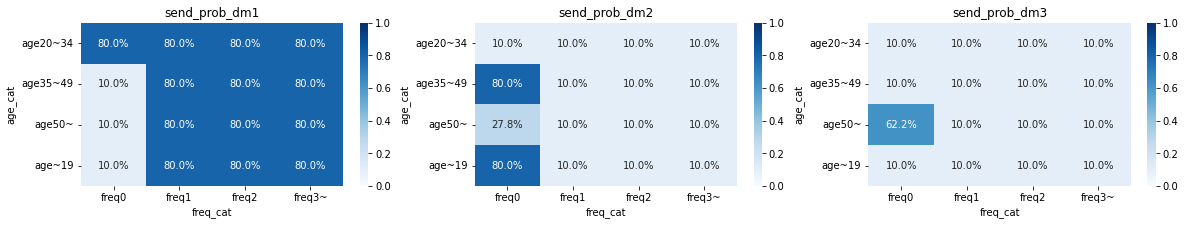

In [113]:
fig, axes = plt.subplots(1,3, figsize=(20,3))
for i, ptn in enumerate(['send_prob_dm1', 'send_prob_dm2', 'send_prob_dm3']):
    seg_send_pivot_df = pd.pivot_table(seg_send_df, ptn, index='age_cat', columns=['freq_cat'], aggfunc='mean')
    sns.heatmap(seg_send_pivot_df, annot=True, fmt='.1%', cmap='Blues', ax=axes[i], vmin=0, vmax=1)
    axes[i].set_title(f'{ptn}')
plt.show()

In [121]:
seg_send_df['num_cust'] = seg_send_df['segment_id'].apply(lambda x: Ns[x])
seg_send_df['send_num_dm1'] = seg_send_df['num_cust'] * seg_send_df['send_prob_dm1']
seg_send_df['send_num_dm2'] = seg_send_df['num_cust'] * seg_send_df['send_prob_dm2']
seg_send_df['send_num_dm3'] = seg_send_df['num_cust'] * seg_send_df['send_prob_dm3']
seg_send_df.head()

,segment_id,age_cat,freq_cat,send_prob_dm1,send_prob_dm2,send_prob_dm3,num_cust,send_num_dm1,send_num_dm2,send_num_dm3
0,1,age~19,freq0,0.1,0.8,0.1,200,20.0,160.0,20.0
1,2,age~19,freq1,0.8,0.1,0.1,150,120.0,15.0,15.0
2,3,age~19,freq2,0.8,0.1,0.1,50,40.0,5.0,5.0
3,4,age~19,freq3~,0.8,0.1,0.1,100,80.0,10.0,10.0
4,5,age20~34,freq0,0.8,0.1,0.1,600,480.0,60.0,60.0


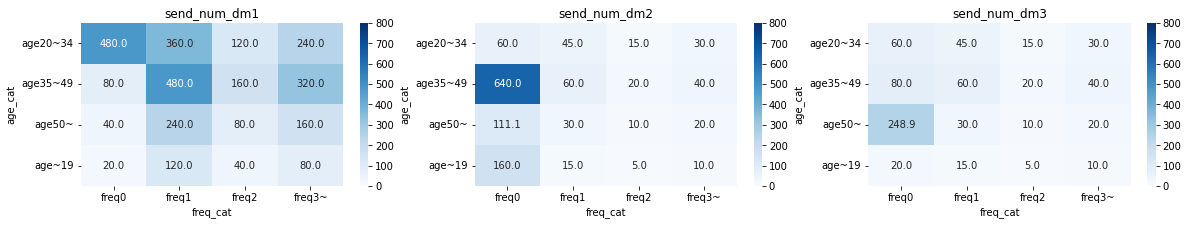

In [122]:
fig, axes = plt.subplots(1,3,figsize=(20,3))
for i, ptn in enumerate(['send_num_dm1', 'send_num_dm2', 'send_num_dm3']):
    seg_send_pivot_df = pd.pivot_table(seg_send_df, values=ptn, index='age_cat', columns=['freq_cat'])
    sns.heatmap(seg_send_pivot_df, vmin=0, vmax=800, cmap='Blues', ax=axes[i], fmt='.1f', annot=True)
    axes[i].set_title(f'{ptn}')
plt.show()